<a target="_blank" href="https://colab.research.google.com/github/taobrienlbl/advanced_earth_science_data_analysis/blob/spring_2023_iub/lessons/12_spectral_analysis_continued/12_workalong_01_filter.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Simple filtering

This notebook demonstrates using the FFT to filter timeseries data.  It also demonstrates a higher-quality approach using a [Butterworth fitler](https://en.wikipedia.org/wiki/Butterworth_filter).

In [1]:
""" Import libraries. """
import numpy as np
import numpy.fft as fft
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
""" Load the data file. """

data_url = "https://raw.githubusercontent.com/taobrienlbl/advanced_earth_science_data_analysis/spring_2023_iub/lessons/11_spectral_analysis_intro/cannelton_flow.dat"

# load the data
data_pd = pd.read_csv(data_url, sep = "\t", skiprows = 30, names = ["agency", "id", "date", "discharge", "flag"], parse_dates=["date"])

data_pd.head()

,agency,id,date,discharge,flag
0,USGS,3303280,1975-10-01,94800,A
1,USGS,3303280,1975-10-02,79900,A
2,USGS,3303280,1975-10-03,69000,A
3,USGS,3303280,1975-10-04,74700,A
4,USGS,3303280,1975-10-05,71700,A


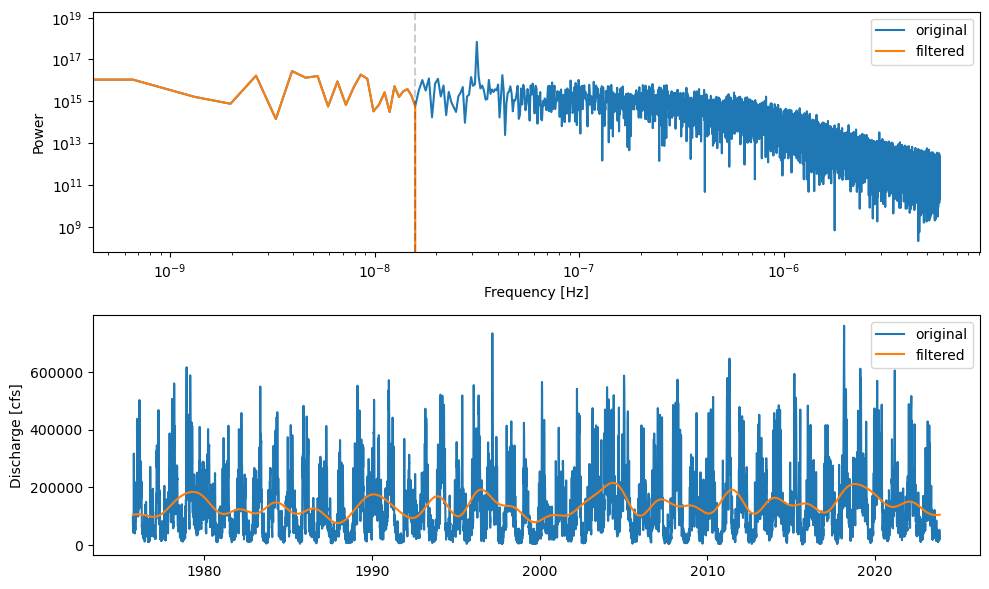

In [3]:
""" Filter the data using a naive cutoff filter. """

# get the fourier transform of the data
discharge_fft = fft.rfft(data_pd["discharge"])

# get the frequencies
dt = 1 # day
dt = dt * 24 * 60 * 60 # seconds (86400)
freqs = fft.rfftfreq(len(data_pd["discharge"]), dt) # 1 / seconds [Hz]

# define the cutoff frequency
cutoff_period = 2 # years
cutoff_period = cutoff_period * 365.25 * 24 * 60 * 60 # seconds
cutoff_freq = 1 / cutoff_period # Hz

# find frequencies that are higher than the cutoff
i_high_freq = freqs > cutoff_freq

# set the FFT to zero for those frequencies
discharge_fft_filtered = discharge_fft.copy()
discharge_fft_filtered[i_high_freq] = 0

# invert the FFT to get the filtered timeseries
discharge_filtered = fft.irfft(discharge_fft_filtered)

fig, axs = plt.subplots(2, 1, figsize = (10, 6))

# plot the original and filtered spectrum
ax = axs[0]
ax.plot(freqs, np.abs(discharge_fft)**2, label = "original")
ax.plot(freqs, np.abs(discharge_fft_filtered)**2, label = "filtered")
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Power")
ax.set_xscale("log")
ax.set_yscale("log")
# draw a line at the cutoff frequency
ax.axvline(cutoff_freq, color = "k", linestyle = "--", alpha = 0.2)
ax.legend()

# plot the original and filtered timeseries
ax = axs[1]
ax.plot(data_pd["date"], data_pd["discharge"], label = "original")
ax.plot(data_pd["date"], discharge_filtered, label = "filtered")
ax.set_xlabel("")
ax.set_ylabel("Discharge [cfs]")
ax.legend()

plt.tight_layout()
plt.show()

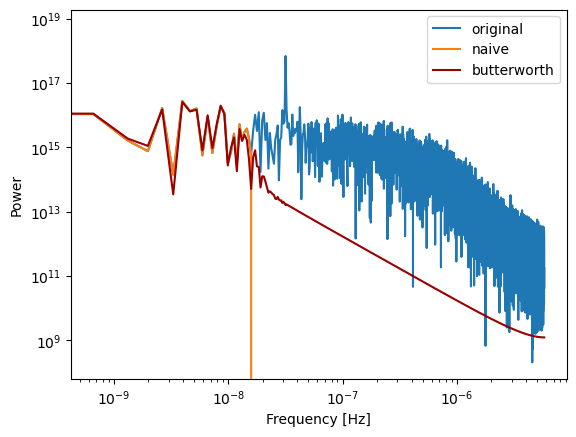

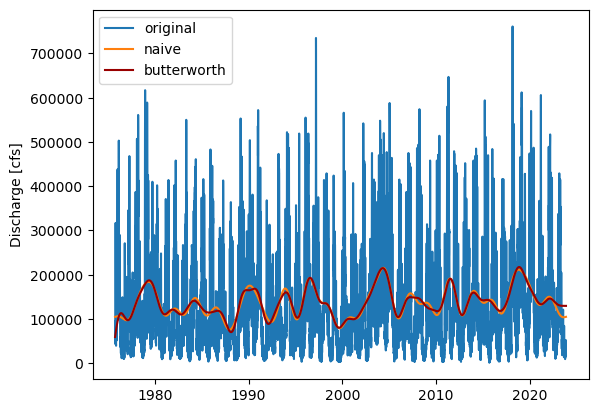

In [4]:
""" Filter the data using a Butterworth filter. """

from scipy.signal import butter, filtfilt

# define the butterworth filter properties
order = 5 # filter order

# get the Nyquist frequency
nyquist_freq = 1 / (2 * dt)
cutoff_period = 2 # years
cutoff_period = cutoff_period * 365.25 * 24 * 60 * 60 # seconds
cutoff_freq = 1 / cutoff_period # Hz
cutoff_freq_norm = cutoff_freq / nyquist_freq

# get the butterworth filter coefficients
b, a = butter(order, cutoff_freq_norm, btype = "lowpass")

# apply the filter
discharge_filtered_butter = filtfilt(b, a, data_pd["discharge"])

# get the FFT of the filtered timeseries
discharge_filtered_butter_fft = fft.rfft(discharge_filtered_butter)

# plot all three power spectra
fig, ax = plt.subplots()
ax.plot(freqs, np.abs(discharge_fft)**2, label = "original")
ax.plot(freqs, np.abs(discharge_fft_filtered)**2, label = "naive")
ax.plot(freqs, np.abs(discharge_filtered_butter_fft)**2, label = "butterworth", color = "#990000")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Power")
ax.legend()
plt.show()

# plot all three timeseries
fig, ax = plt.subplots()
ax.plot(data_pd["date"], data_pd["discharge"], label = "original")
ax.plot(data_pd["date"], discharge_filtered, label = "naive")
ax.plot(data_pd["date"], discharge_filtered_butter, label = "butterworth", color = "#990000")
ax.set_xlabel("")
ax.set_ylabel("Discharge [cfs]")
ax.legend()
plt.show()



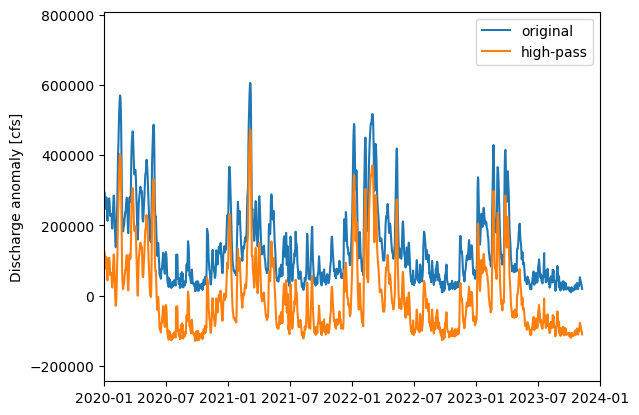

In [5]:
""" Calculate and plot the high-pass data """

# get the high-pass data
discharge_highpass = data_pd["discharge"] - discharge_filtered_butter

# plot the high-pass data
fig, ax = plt.subplots()
ax.plot(data_pd["date"], data_pd["discharge"], label = "original")
ax.plot(data_pd["date"], discharge_highpass, label = "high-pass")
ax.set_xlabel("")
ax.set_ylabel("Discharge anomaly [cfs]")
# focus on 2023
ax.set_xlim(pd.Timestamp("2020-01-01"), pd.Timestamp("2024-01-01"))
ax.legend()
plt.show()
